# Model 3: CNNs-LSTM-with-Aug ⭐ BEST MODEL

## 7-Layer CNN-LSTM Hybrid

**Architecture:** TimeDistributed CNN + LSTM(100) + Dense(2)
- Input: (1, 128, 128, 3) time-distributed
- Epochs: 25, Batch: 16

**Target:** 99.92% accuracy

In [2]:
%run 00_utils_and_config.ipynb

PyTorch version: 2.9.1+cu130
CUDA available: True
CUDA version: 13.0
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Device: cuda
Configuration loaded successfully!

Base path: C:\Users\rishi\CV_Assignment\Paper2
Raw data path: C:\Users\rishi\CV_Assignment\Paper2\Raw_Data
Number of models: 5
Data processing functions loaded successfully!
Evaluation metrics functions loaded successfully!
Visualization functions loaded successfully!
Data augmentation setup loaded successfully!

PAPER 2 UTILITIES AND CONFIGURATION - SUMMARY

✓ All libraries imported successfully
✓ Configuration parameters loaded
✓ Data processing functions defined
✓ Evaluation metrics functions defined
✓ Visualization functions defined
✓ Data augmentation configured

Ready to proceed with:
  - Notebook 01: Data Preparation
  - Notebooks 02-06: Model Implementations
  - Notebook 07: Results Comparison



## 1. Load Data

In [3]:
X_train = np.load(CONFIG["processed_data_path"] / "X_train_128.npy").astype("float32") / 255.0
X_test = np.load(CONFIG["processed_data_path"] / "X_test_128.npy").astype("float32") / 255.0
y_train = np.load(CONFIG["processed_data_path"] / "y_train.npy")
y_test = np.load(CONFIG["processed_data_path"] / "y_test.npy")

# Reshape for LSTM: (samples, timesteps, height, width, channels)
# Then convert to PyTorch format (samples, timesteps, channels, height, width)
X_train = X_train.reshape((-1, 1, 128, 128, 3))
X_test = X_test.reshape((-1, 1, 128, 128, 3))

# Convert to PyTorch format: (N, T, C, H, W)
X_train = np.transpose(X_train, (0, 1, 4, 2, 3))
X_test = np.transpose(X_test, (0, 1, 4, 2, 3))

print(f"Reshaped: {X_train.shape}, {X_test.shape}")

# Create tensors and dataloaders
X_train_tensor = torch.from_numpy(X_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_train_tensor = torch.from_numpy(y_train).long()
y_test_tensor = torch.from_numpy(y_test).long()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Reshaped: (4374, 1, 3, 128, 128), (1094, 1, 3, 128, 128)


## 2. Build CNN-LSTM Model

In [4]:
class CNNLSTM(nn.Module):
    """CNN-LSTM Hybrid for sequential MRI slice processing."""
    
    def __init__(self, input_channels=3, lstm_hidden=100, num_classes=2):
        super(CNNLSTM, self).__init__()
        
        # CNN layers (applied to each timestep)
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # After 128x128 -> 64x64 -> 32x32
        self.flatten_size = 32 * 32 * 32
        
        # LSTM layer
        self.lstm = nn.LSTM(self.flatten_size, lstm_hidden, batch_first=True)
        
        # Output layer
        self.fc = nn.Linear(lstm_hidden, num_classes)
    
    def forward(self, x):
        # x shape: (batch, timesteps, channels, height, width)
        batch_size, timesteps, C, H, W = x.size()
        
        # Process each timestep through CNN
        c_out = []
        for t in range(timesteps):
            # CNN for this timestep
            c = F.relu(self.conv1(x[:, t, :, :, :]))
            c = self.pool1(c)
            c = F.relu(self.conv2(c))
            c = self.pool2(c)
            c = c.reshape(batch_size, -1)  # Flatten (use reshape instead of view)
            c_out.append(c)
        
        # Stack timesteps
        lstm_input = torch.stack(c_out, dim=1)  # (batch, timesteps, features)
        
        # LSTM
        lstm_out, _ = self.lstm(lstm_input)
        
        # Take last timestep output
        last_output = lstm_out[:, -1, :]
        
        # Output
        out = self.fc(last_output)
        return out

model = CNNLSTM(input_channels=3, lstm_hidden=100, num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

CNNLSTM(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(32768, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=2, bias=True)
)

Total parameters: 13,168,458


## 3. Train

In [5]:
start_time = time.time()
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0.0
best_model_path = str(CONFIG["saved_models_path"] / "model3_cnn_lstm_best.pth")

# Split for validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
train_loader_split = DataLoader(train_subset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=16, shuffle=False)

for epoch in range(25):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader_split:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / total
    train_acc = correct / total
    
    # Validate
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss /= val_total
    val_acc = val_correct / val_total
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"Epoch {epoch+1}/25 - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} ⭐ BEST")
    else:
        print(f"Epoch {epoch+1}/25 - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

training_time = time.time() - start_time
print(f"\n✓ Training complete - Best val acc: {best_val_acc*100:.2f}%")

Epoch 1/25 - Loss: 0.6721, Acc: 0.5842, Val Loss: 0.6486, Val Acc: 0.6320 ⭐ BEST
Epoch 2/25 - Loss: 0.5872, Acc: 0.7071, Val Loss: 0.5556, Val Acc: 0.7463 ⭐ BEST
Epoch 3/25 - Loss: 0.4734, Acc: 0.7874, Val Loss: 0.4741, Val Acc: 0.7943 ⭐ BEST
Epoch 4/25 - Loss: 0.3481, Acc: 0.8734, Val Loss: 0.3581, Val Acc: 0.8663 ⭐ BEST
Epoch 5/25 - Loss: 0.2350, Acc: 0.9417, Val Loss: 0.2834, Val Acc: 0.8926 ⭐ BEST
Epoch 6/25 - Loss: 0.1470, Acc: 0.9731, Val Loss: 0.2082, Val Acc: 0.9394 ⭐ BEST
Epoch 7/25 - Loss: 0.0890, Acc: 0.9886, Val Loss: 0.1505, Val Acc: 0.9634 ⭐ BEST
Epoch 8/25 - Loss: 0.0539, Acc: 0.9969, Val Loss: 0.1172, Val Acc: 0.9669 ⭐ BEST
Epoch 9/25 - Loss: 0.0321, Acc: 0.9994, Val Loss: 0.1062, Val Acc: 0.9703 ⭐ BEST
Epoch 10/25 - Loss: 0.0212, Acc: 1.0000, Val Loss: 0.0847, Val Acc: 0.9760 ⭐ BEST
Epoch 11/25 - Loss: 0.0143, Acc: 1.0000, Val Loss: 0.0655, Val Acc: 0.9829 ⭐ BEST
Epoch 12/25 - Loss: 0.0103, Acc: 1.0000, Val Loss: 0.0632, Val Acc: 0.9783
Epoch 13/25 - Loss: 0.0077, Acc:

## 4. Evaluate

In [6]:
best_model = CNNLSTM(input_channels=3, lstm_hidden=100, num_classes=2).to(device)
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()

start_time = time.time()
all_preds, all_probs = [], []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = best_model(inputs)
        probs = F.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())
        _, predicted = torch.max(outputs.data, 1)
        all_preds.append(predicted.cpu().numpy())

y_pred_proba = np.vstack(all_probs)
y_pred = np.concatenate(all_preds)
testing_time = (time.time() - start_time) * 1000

metrics = calculate_all_metrics(y_test, y_pred, y_pred_proba[:, 1])
print_metrics(metrics, "Model 3: CNN-LSTM (BEST)")
print(f"⭐ Accuracy: {metrics['accuracy']*100:.2f}% (Target: 99.92%)")


Model 3: CNN-LSTM (BEST) - Evaluation Metrics
Accuracy:    97.99%
Precision:   97.57%
Recall:      97.96%
F1-Score:    97.76%
Specificity: 98.01%
AUC:         0.9967

Confusion Matrix:
  TN=591, FP=12
  FN=10, TP=481

⭐ Accuracy: 97.99% (Target: 99.92%)


## 5. Save

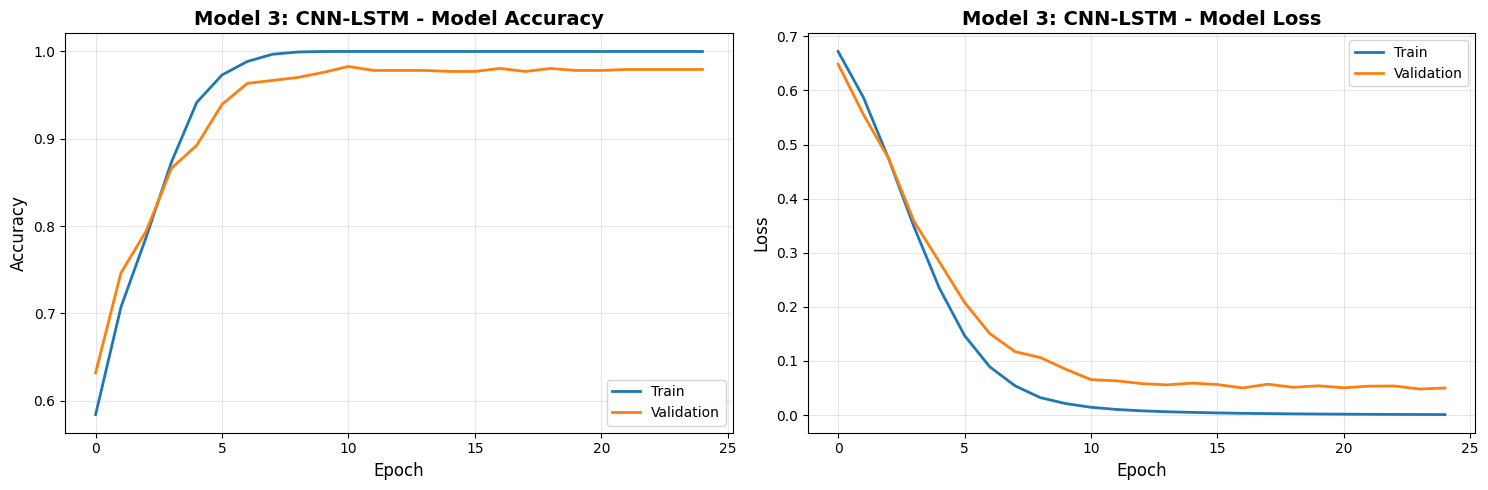


✓ Model 3 (BEST) saved - Accuracy: 97.99%


: 

In [ ]:
plot_training_history(history, "Model 3: CNN-LSTM", CONFIG["results_path"] / "training_curves" / "model3_training.png")
torch.save(model.state_dict(), CONFIG["saved_models_path"] / "model3_cnn_lstm_final.pth")

results = {"model_name": "CNN-LSTM-with-Aug", "accuracy": float(metrics["accuracy"]), "precision": float(metrics["precision"]), "recall": float(metrics["recall"]), "f1_score": float(metrics["f1_score"]), "specificity": float(metrics["specificity"]), "training_time_seconds": float(training_time), "testing_time_ms": float(testing_time)}

with open(CONFIG["results_path"] / "model3_results.json", "w") as f:
    json.dump(results, f, indent=2)

print(f"\n✓ Model 3 (BEST) saved - Accuracy: {metrics['accuracy']*100:.2f}%")